# MNIST Dataset 적용해보기

## data loader


In [1]:
import csv
import numpy as np

IMG_SIZE = int(784)

def train_data_loader():
    file = open('./digit-recognizer/train.csv', 'r')
    reader = csv.reader(file, delimiter=',')
    ans = []
    img = []
    
    for idx, row in enumerate(reader):
        if idx != 0:
            ans.append(np.zeros(10))
            ans[idx-1][int(row[0])] = 1
            
            img.append(row[1:IMG_SIZE])
    
    return (ans, img)

train_ans, train_img = train_data_loader()
train_ans = np.array(train_ans, dtype=float)
train_img = np.array(train_img, dtype=float)

## data check

In [2]:
train_img = train_img[0:1000]
train_ans = train_ans[0:1000]
print(train_img.shape)
print(train_ans[0])

(1000, 783)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


## Affine 계층 구현

In [3]:
# Affine 계층
#
class Affine:
    def __init__(self, input_size, output_size):
        self.W = 0.01 * np.random.randn(input_size, output_size) * np.sqrt(1.0 / input_size)
        #print(self.W)
        self.B = 0.01 * np.random.randn(output_size)
    
    # input 벡터를 입력받고
    # output을 반환한다.
    def forwardProp(self, X):
        self.X = X
        self.Y = self.X.dot(self.W) + self.B
        #print('Y: ', self.Y)
        return self.Y
    # 가중치와 편향을 변경하고
    # input의 오차를 반환한다.
    def backwardProp(self, error, learning_rate = 0.001):
        dLdY = error
        dLdX = dLdY.dot(np.transpose(self.W))
        dLdW = np.transpose(self.X).dot(dLdY)
        dLdB = dLdY
        
        self.W = self.W - learning_rate*dLdW
        self.B = self.B - learning_rate*dLdB
        
        return dLdX        
        

## ReLU 계층 구현

In [4]:
class ReLU:
    # size: input과 output의 수
    def __init__(self, size):
        self.size = size
        
    # input 행렬을 입력받고
    # output을 반환한다.
    def forwardProp(self, X):
        # 0보다 작은 값은 0으로 바꿔버린다.
        #print(X)
        self.Y = np.where(X < 0, 0, X)
        #print(self.Y)
        return self.Y        
    
    # 가중치와 편향을 변경하고
    # input의 오차를 반환한다.
    def backwardProp(self, error):
        dLdX = error * self.Y
        return dLdX

## Softmax 계층 구현

In [5]:
class Softmax:
    # size: input과 output의 수
    def __init__(self, size):
        self.size = size
        
    def forwardProp(self, X):
        theta = 0.000001
        self.X = X - np.max(X)
        self.Y = np.exp(self.X)
        for idx, row in enumerate(self.Y):
            self.Y[idx] = row / (np.sum(self.Y[idx]) + theta)
        
        return self.Y
    
    def backwardProp(self, error):
        theta = 0.000001
        dLdX = []
        for idx in range(0, len(error)):
            S = np.sum(self.Y[idx])
            dLdX.append((error[idx]* np.exp(self.Y[idx]) * (S - 1)) / (S + theta))
        return np.array(dLdX)

## CEE 계층 구현

In [6]:
class CEE:
    # size: input과 output의 수
    def __init__(self, size):
        self.size = size
    
    def getError(self, X, answer):
        theta = 0.000001
        self.error = -np.sum(answer * np.log(X + theta))
        return self.error
    def backwardProp(self, X, ans):
        theta = 0.000001
        return -ans / (X + theta)

## Softmax-with-Loss

In [10]:
class SoftmaxLoss:
    def __init__(self):
        self.loss = None
        self.Y = None
        self.T = None
    
    # 벡터에 대한 softmax
    def softmax(self, X):
        x = X - np.max(X)        
        return x / np.sum(x)
    
    def CEE(self, Y, T):
        theta = 0.0001
        return -np.sum(T * np.log(Y + theta))
    
    def forwardProp(self, X, T):
        self.T = T
        self.Y = []
        self.loss = 0.
        for r in range(self.T.shape[0]):
            self.Y.append(self.softmax(X[r]))
            self.loss += self.CEE(self.Y[r], self.T[r])
        self.Y = np.array(self.Y)
        #print(self.Y)
        self.loss /= self.T.shape[0]
        return self.loss
        
    def backwardProp(self):
        batch_size = self.T.shape[0]
        return (self.Y - self.T) / batch_size
        

## 조합

input(100, 784) - Affine(100, 1000) - ReLU(100, 1000) - Affine(100, 1000) - ReLU(100, 1000) - Affine((100, 1000) -> (100, 10)) - ReLU(100, 10) - Softmax(100, 10) - CCE(100, 10)

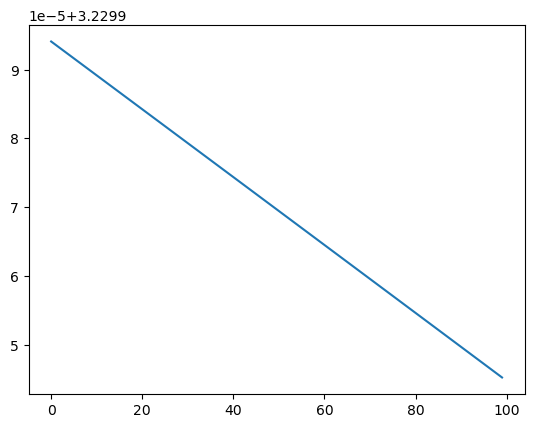

In [11]:
import matplotlib.pyplot as plt

layers = [
    [Affine(783, 1000), ReLU(1000)],
    [Affine(1000, 1000), ReLU(1000)],
    [Affine(1000, 10), ReLU(10)],
    SoftmaxLoss()
]

steps = np.arange(0, 100, 1)
errors = []
for step in steps:
    X = layers[0][0].forwardProp(train_img)
    X = layers[0][1].forwardProp(X)
    X = layers[1][0].forwardProp(X)
    X = layers[1][1].forwardProp(X)
    X = layers[2][0].forwardProp(X)
    X = layers[2][1].forwardProp(X)
    E = layers[3].forwardProp(X, train_ans)
    
    #print(E)
    errors.append(E)
    L = layers[3].backwardProp()
    L = layers[2][1].backwardProp(L)
    L = layers[2][0].backwardProp(L)
    L = layers[1][1].backwardProp(L)
    L = layers[1][0].backwardProp(L)
    L = layers[0][1].backwardProp(L)
    L = layers[0][0].backwardProp(L)

plt.plot(steps, errors)
plt.show()
    

In [9]:
print(layers[0][0].W)

[[ 4.05149458e-04 -3.92074384e-04  3.93341614e-04 ...  5.80698314e-04
  -4.47780629e-04  2.21490908e-06]
 [ 2.74817581e-05 -5.61017727e-04  2.85075613e-04 ... -2.24400328e-04
   1.54010624e-04  2.25487947e-04]
 [-4.09485359e-05  2.04894986e-05  2.45552862e-04 ...  1.58865382e-04
  -5.53956142e-05  1.28420506e-05]
 ...
 [ 1.80917054e-04 -2.42228070e-04  1.14661477e-04 ...  4.58557026e-05
   3.52662754e-04  3.99381911e-04]
 [ 4.54422509e-04  9.99446580e-05 -4.19241768e-06 ...  3.11025356e-04
  -3.13683700e-04  7.81240250e-04]
 [-4.27752786e-04 -6.54526263e-04 -5.79598950e-04 ...  1.18289124e-04
   3.67489823e-04 -4.00026069e-04]]
